In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches
from highlight_text import fig_text

### Importing data


In [9]:
edata = pd.read_csv("C:\\Users\\amaia\\Downloads\\ML project\\lung_cancer_mortality_data_test_v2.csv")
#renaming the countys column to match the geopandas file for when we merge
edata = edata.rename(columns={"country" : "Country"})

In [6]:
#For reading the geopanadas files
import geopandas as gpd

world = gpd.read_file("C:\\Users\\amaia\\Downloads\\ne_110m_admin_0_countries\\ne_110m_admin_0_countries.shp")
# filter on europe only
europe = world[world['CONTINENT'] == 'Europe']

### Subsetting data to calculate % mortality of patients by region

In [10]:
#LOOKING AT MORTALITY RATE BY COUNTRY

#count of deaths by country
survived_false= edata[(edata["survived"] == 0)]
count_map = survived_false.groupby(["Country"]).size().reset_index(name="deaths")

#total count of patients by country
total_group_map= edata.groupby(["Country"]).size().reset_index(name="total")

#CREATING SURVIVAL RATE METRIC COUNT(SURIVIED)/ COUNT(TOTAL DIGANOSED)
count_map["mortality_rate"] = count_map["deaths"]/total_group_map["total"]

#DROPPING DEATHS AS WE NOW HAVE MORTALITY % AS A VALUE NOW
count_map.drop(["deaths"], axis = 1, inplace = True)
count_map

,Country,mortality_rate
0,Austria,0.823529
1,Belgium,0.727273
2,Bulgaria,0.750000
3,Croatia,0.723404
4,Cyprus,0.800000
5,Czech Republic,0.862069
6,Denmark,0.700000
7,Estonia,0.820513
8,Finland,0.820513
9,France,0.838710


### Merging data with geopandas data

In [11]:
#merging data on country
data = europe.merge(count_map, how='left',
                    left_on='NAME', right_on='Country')

#droping countries in the geopandas which are not in our data 
data.dropna(subset=['mortality_rate'], inplace=True)
#rounding number and creating a percentage
data['mortality_rate'] = round(data['mortality_rate']*100, 1)

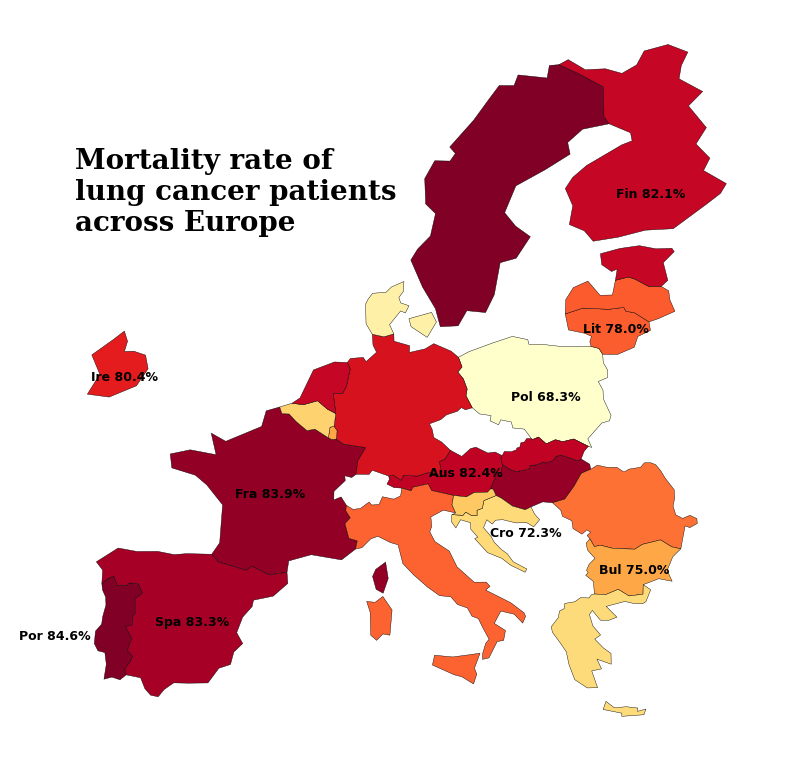

In [70]:
# initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# define colors
cmap = cm.YlOrRd
min_rate, max_rate = 68.3, 84.6
norm = mcolors.Normalize(vmin=min_rate, vmax=max_rate)

# create the plot
data.plot(column='mortality_rate', cmap=cmap, norm=norm, ax=ax,edgecolor='black', linewidth=0.3)

# custom axis - creates the graph axis but removes them from being displayed
ax.set_xlim(-15, 35)
ax.set_ylim(32, 72)
ax.axis('off')


fig.text(0.1, 0.7, 'Mortality rate of \nlung cancer patients\nacross Europe',
         fontsize=20, fontweight='bold', fontfamily='serif')

# compute centroids for annotations
data_projected = data.to_crs(epsg=3035)
data_projected['centroid'] = data_projected.geometry.centroid
data['centroid'] = data_projected['centroid'].to_crs(data.crs)
countries_to_annotate = ['France',
                         'Lithuania', 'Finland', 'Austria', 'Croatia', 'Portugal', 'Bulgaria', 'Poland', "Spain", "Ireland"]

#these are the positions of the text on the countries
adjustments = {
    'France': (9, 3),
    'Spain': (0, -1),
    'Italy': (-2.4, 2),
    'Lithuania': (0, -0.6),
    'Finland': (0, -2.5),
    'Bulgaria': (-0.1, -0.7),
    'Ireland': (0, -1),
    'Croatia': (1.5, -1),
    'Malta': (0, -1),
    'Austria': (0.1, -0.5),
    'Portugal': (-4.5, -1),
    'Poland': (0, -1),
}
# annotate countries
for country in countries_to_annotate:

    # get centroid
    centroid = data.loc[data['NAME'] == country, 'centroid'].values[0]
    x, y = centroid.coords[0]

    # get corrections
    x += adjustments[country][0]
    y += adjustments[country][1]

    # get rate and annotate
    rate = data.loc[data['NAME'] == country, 'mortality_rate'].values[0]
    ax.annotate(f'{country[:3]} {rate}%', (x, y), textcoords="offset points", xytext=(5, 5),
                ha='center', fontsize=9, fontfamily='DejaVu Sans', color='black', fontweight = "bold")

# display the plot
plt.tight_layout()
plt.show()

### Plotting 'Health score'
This is a metric which will combine bmi, cholesterol level, hypotension presence, cirrhosis presence, asthma presence and other cancer presence

To be able to combine the values of these the values which are continous must be scaled


In [40]:
from sklearn.preprocessing import StandardScaler

#Creating a dataframe of all values which are needed for the score
scaled_data =  edata[["Country","bmi","cholesterol_level", "hypertension", "asthma" , "cirrhosis", "other_cancer"]]

#scaling continuous columns
scaler = StandardScaler()
scaled_data.loc[:,['bmi', "cholesterol_level"]] = scaler.fit_transform(scaled_data[['bmi', "cholesterol_level"]])

In [41]:
#Creating the score by adding the values together
scaled_data.loc[:,"score"]  = (scaled_data["bmi"] + scaled_data["cholesterol_level"] + scaled_data["hypertension"] 
                        + scaled_data["asthma"] + scaled_data["cirrhosis"] + scaled_data["other_cancer"])

C:\Users\amaia\AppData\Local\Temp\ipykernel_9612\719994158.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaled_data.loc[:,"score"]  = (scaled_data["bmi"] + scaled_data["cholesterol_level"] + scaled_data["hypertension"]


## Grouping the data by country and calculating a mean score for plotting

In [63]:
test = scaled_data.groupby(["Country"])["score"].mean().reset_index(name="health")

In [64]:
#Merging data as previous figure
data_score = europe.merge(test, how='left',
                    left_on='NAME', right_on='Country')

data_score.dropna(subset=['health'], inplace=True)




In [69]:
#changing data type as for some reason it was object
data_score["health"] = data_score["health"].astype(float)
#rounding to 2 d.p.
data_score['health'] = round(data_score['health'], 2)

C:\Users\amaia\AppData\Local\Temp\ipykernel_9612\2380192989.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


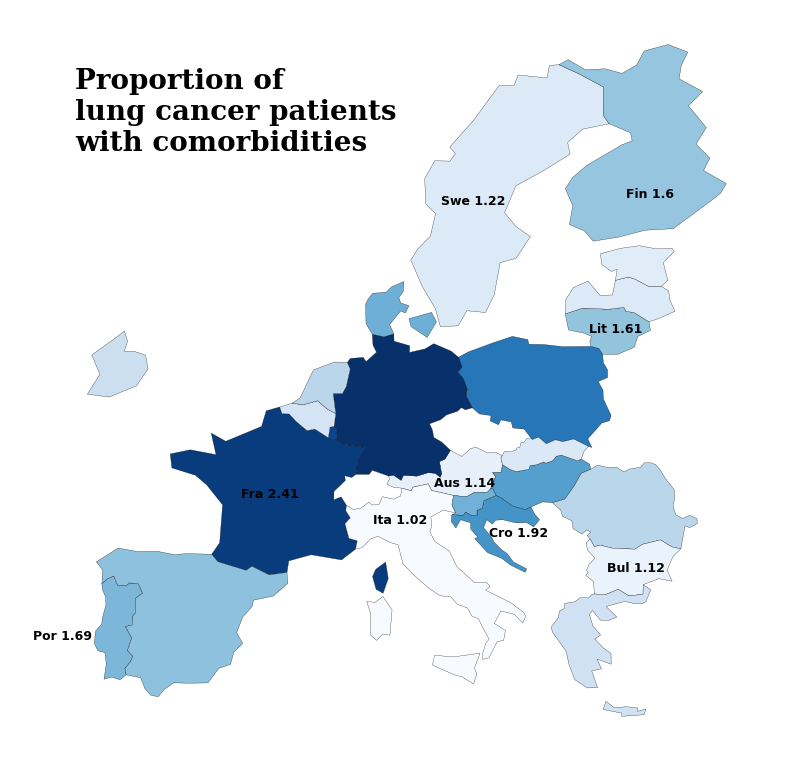

In [68]:
# initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# define colors
cmap = cm.get_cmap('Blues')
min_rate, max_rate = data_score['health'].min(), data_score['health'].max()
norm = mcolors.Normalize(vmin=min_rate, vmax=max_rate)

# create the plot
data_score.plot(column='health', cmap=cmap, norm=norm, ax=ax,edgecolor='black', linewidth=0.2)

# custom axis
ax.set_xlim(-15, 35)
ax.set_ylim(32, 72)
ax.axis('off')

fig.text(0.1, 0.8, 'Proportion of \nlung cancer patients\nwith comorbidities',
         fontsize=20, fontweight='bold', fontfamily='serif')

# compute centroids for annotations
data_projected = data_score.to_crs(epsg=3035)
data_projected['centroid'] = data_projected.geometry.centroid
data_score['centroid'] = data_projected['centroid'].to_crs(data_score.crs)
countries_to_annotate = ['France', 'Lithuania', 'Finland', 'Austria', 'Croatia', 'Portugal', 'Bulgaria', "Italy", "Sweden"]
adjustments = {
    'France': (9, 3),
    'Italy': (-2.4, 2),
    'Lithuania': (0, -0.6),
    'Finland': (0, -2.5),
    'Romania': (0, -0.5),
    'Bulgaria': (0, -0.6),
    'Greece': (-1.2, -0.8),
    'Croatia': (1, -1),
    'Cyprus': (0, -1),
    'Ireland': (0, -1),
    'Malta': (0, -1),
    'Slovenia': (0, -1),
    'Slovakia': (-0.7, -0.8),
    'Estonia': (0, -0.7),
    'Latvia': (1, -0.5),
    'Belgium': (0, -0.7),
    'Austria': (0, -1),
    'Spain': (0, -1),
    'Portugal': (-4, -1),
    'Luxembourg': (0, -1),
    'Germany': (-0.2, 0),
    'Hungary': (-0.3, -1),
    'Czechia': (0, -1),
    'Poland': (0, -1),
    'Sweden': (-1.5, -1),
    'Denmark': (0, -1),
    'Netherlands': (0, 0),
    'Switzerland': (0, -0.5),
}
# annotate countries
for country in countries_to_annotate:

    # get centroid
    centroid = data_score.loc[data['NAME'] == country, 'centroid'].values[0]
    x, y = centroid.coords[0]

    # get corrections
    x += adjustments[country][0]
    y += adjustments[country][1]

    # get rate and annotate
    rate = data_score.loc[data['NAME'] == country, 'health'].values[0]
    ax.annotate(f'{country[:3]} {rate}', (x, y), textcoords="offset points", xytext=(5, 5),
                ha='center', fontsize=9, fontfamily='DejaVu Sans', color='black', fontweight = "bold")

# display the plot
plt.tight_layout()
plt.show()

## exposure to smoke

In [72]:
#only people who have smoked, currently smoked or been exposed to smoke
smoking_positive= edata[(edata["smoking_status"] != "Never Smoked")]

count_smokers = smoking_positive.groupby(["Country"]).size().reset_index(name="smokers")

#total count
total_group_by_smoking= edata.groupby(["Country"]).size().reset_index(name="total")


#create percentage of patients exposed
count_smokers["smoking exposure %"] = count_smokers["smokers"]/total_group_by_smoking["total"]*100
count_smokers.drop(["smokers"], axis = 1, inplace = True)

In [73]:
data_smoker = europe.merge(count_smokers, how='left',
                    left_on='NAME', right_on='Country')

data_smoker.dropna(subset=['smoking exposure %'], inplace=True)

data_smoker['smoking exposure %'] = round(data_smoker['smoking exposure %'])

C:\Users\amaia\AppData\Local\Temp\ipykernel_9612\2604136918.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Reds')


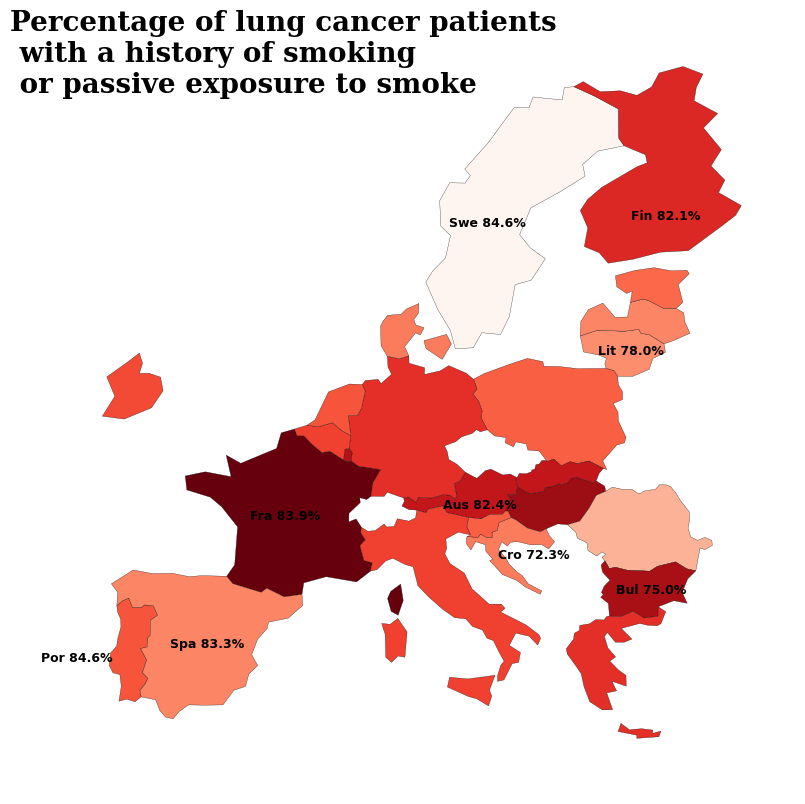

In [75]:
# initialize the figure
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# define colors
cmap = cm.get_cmap('Reds')
min_rate, max_rate = data_smoker['smoking exposure %'].min(), data_smoker['smoking exposure %'].max()
norm = mcolors.Normalize(vmin=min_rate, vmax= 90)

# create the plot
data_smoker.plot(column='smoking exposure %', cmap=cmap, norm=norm, ax=ax,edgecolor='black', linewidth=0.2)

# custom axis
ax.set_xlim(-15, 35)
ax.set_ylim(32, 72)
ax.axis('off')

fig.text(0, 0.9, 'Percentage of lung cancer patients \n with a history of smoking \n or passive exposure to smoke',
         fontsize=20, fontweight='bold', fontfamily='serif')

# compute centroids for annotations
data_projected = data_smoker.to_crs(epsg=3035)
data_projected['centroid'] = data_projected.geometry.centroid
data_smoker['centroid'] = data_projected['centroid'].to_crs(data_score.crs)
countries_to_annotate = ['France',
                         'Lithuania', 'Finland', 'Austria', 'Croatia', 'Portugal', 'Bulgaria', "Spain", "Sweden"]
adjustments = {
    'France': (9, 3),
    'Italy': (-2.4, 2),
    'Lithuania': (0, -0.6),
    'Finland': (0, -2.5),
    'Romania': (0, -0.5),
    'Bulgaria': (0, -0.6),
    'Greece': (-1.2, -0.8),
    'Croatia': (1, -1),
    'Cyprus': (0, -1),
    'Ireland': (0, -1),
    'Malta': (0, -1),
    'Slovenia': (0, -1),
    'Slovakia': (-0.7, -0.8),
    'Estonia': (0, -0.7),
    'Latvia': (1, -0.5),
    'Belgium': (0, -0.7),
    'Austria': (0, -1),
    'Spain': (0, -1),
    'Portugal': (-4, -1),
    'Luxembourg': (0, -1),
    'Germany': (-0.2, 0),
    'Hungary': (-0.3, -1),
    'Czechia': (0, -1),
    'Poland': (0, -1),
    'Sweden': (-1.5, -1),
    'Denmark': (0, -1),
    'Netherlands': (0, 0),
    'Switzerland': (0, -0.5),
}
# annotate countries
for country in countries_to_annotate:

    # get centroid
    centroid = data_smoker.loc[data['NAME'] == country, 'centroid'].values[0]
    x, y = centroid.coords[0]

    # get corrections
    x += adjustments[country][0]
    y += adjustments[country][1]

    # get rate and annotate
    rate = data.loc[data['NAME'] == country, 'mortality_rate'].values[0]
    ax.annotate(f'{country[:3]} {rate}%', (x, y), textcoords="offset points", xytext=(5, 5),
                ha='center', fontsize=9, fontfamily='DejaVu Sans', color='black', fontweight = "bold")

# display the plot
plt.tight_layout()
plt.show()